# 05.03 - Hyperparameters and Model Validation

To review from the previous episode, we saw the basic steps for applying a supervised machine learning model:

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

Generally speaking, the first two steps are the most important. Finding the most appropriate **model** and tuning it with the right **hyperparameters** is of fundamental importance, and this section will cover how to perform validation on both of them. 

### Thinking about Model Validation

Model and hyperparameters validation is _deceitfully_ simple: 

1. Choose a model and hyperparameters 
2. Apply it to training data
3. Compare prediction to known value

However, there are good (and "less good") ways of doing it. Let's have a look at both:

### Model validation the wrong way

In [1]:
# loading the data
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a k-neighbors classifier with <code>n_neighbors=1</code>.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [3]:
# training the model
model.fit(X, y)
y_model = model.predict(X)

In [4]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

100% ? Wow, we might just have create the perfect model! Or maybe not. In fact, the flaw here has been training and evaluating the model on the _same data_.

Since KNN simply stores training data and then use it to predict labels by comparing new data to these stored points, it will get 100% accuracy (nearly almost) every time. 

### Model validation the right way: Holdout sets



A better way is to use **holdout sets**, parts of the datasets on which we have not performed model training and that we will use only to check model performance. 

This splitting can be done using the <code>train_test_split</code> utility in Scikit-Learn:

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

C:\Users\Giuseppe\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9066666666666666

### Model validation via cross-validation

In the previous case, an evident drawback is that we didn't get to use 50% of our available dataset to specify the model. There may be useful information that we are missing out on. 

To avoid this issue, and make the validation even more robust, we can use **cross-validation**, where each subset of the data is used both as a training set and as a validation set. 

Here we do two validation trials, alternately using each half of the data as a holdout set.

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

This particular form of cross-validation is a **two-fold cross-validation** — that is, one in which we have split the data into two sets and used each in turn as a validation set.

The concept can be expanded to n-fold, splitting the dataset in n parts and using them all in turn as training and validation sets.

To do it conveniently, we can use the Scikit-Learn's <code>cross_val_score</code>:

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In Scikit-learn there are a number of useful cross-validation schemes useful for particular situation. Let's say we want to cross-validate on a number of folds equal to the number of data points. This is what is known as <code>leave-one-out</code> cross-validation.

### Model Selection

The key question in model selection is: *what do do I do if my estimator is underperforming*?

We can start with four possible answers:

1. Use a more complicated/more flexible model
2. Use a less complicated/less flexible model
3. Gather more training samples
4. Gather more data to add features to each sample

#### The Bias - Variance trade-off

Fundamentally, the question of the *best* model is about finding a sweet spot in the tradeoff between **bias** and **variance**.

A model can usually fall in two categories based on how well it predicts unseen data compared to training data:

1. **Underfitting**, especially for relatively simple models (e.g. linear regression) the model may not take into account many of the intrinsic features of the data and just model it in a simplicistic manner.  
_These type of models are also described as **high bias**._


2. **Overfitting**, complex model can instead run into an opposite issue, modelling noise (or random variations in the training dataset) as intrinsic properties of the process that generated the dataset, therefore generalizing something that is an exception, and not the rule.   
_These type of models are also described as **high variance**._

Usually, underfitting models tend to perform similarly in training and validation when it comes to R^2 (variance explained by the model), while overfitting model tend to be significantly worse in validation than they are in training, where they usually capture a very high proportion of the variance.  

#### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models. Here we will use a polynomial regression model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [9]:
# creating data for our model
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

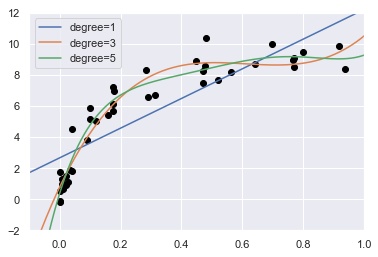

In [10]:
# visualize the data, with polynomial fits of several degrees
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Now an interesting question arises: which polynomial degree offers the best bias-variance trade-off. We can make progress in this by visualizing the validation curve for this particular data and model using <code>validation_curve</code>:

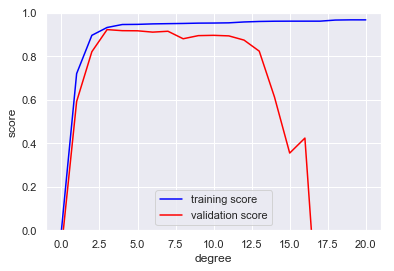

In [15]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

From the learning curve, we will be able to see that our maximum can be found around the third-order polynomial. Let's see how that looks like:

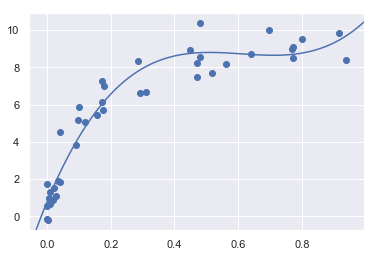

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

### Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data. For example, let's increase the size of our dataset by a factor of 5:

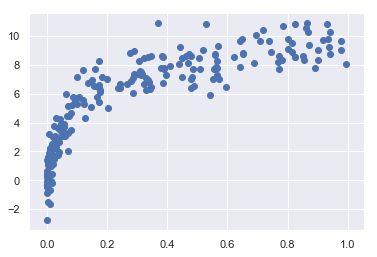

In [16]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

Let's overplot current and previous validation curves, to see how things changed:

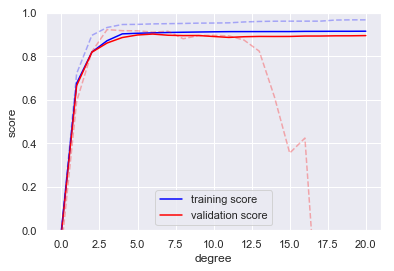

In [17]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');